In [41]:
# 导入库
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, \
    f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV

In [42]:
# 数据处理,sep表示用逗号","分割数据
data  = pd.read_csv('Electrical Grid Data.csv',sep=',')
print(data)

          tau1      tau2      tau3      tau4        p1        p2        p3  \
0     2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1     9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2     8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3     0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4     3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   
...        ...       ...       ...       ...       ...       ...       ...   
9995  2.930406  9.487627  2.376523  6.187797  3.343416 -0.658054 -1.449106   
9996  3.392299  1.274827  2.954947  6.894759  4.349512 -1.663661 -0.952437   
9997  2.364034  2.842030  8.776391  1.008906  4.299976 -1.380719 -0.943884   
9998  9.631511  3.994398  2.757071  7.821347  2.514755 -0.966330 -0.649915   
9999  6.530527  6.781790  4.349695  8.673138  3.492807 -1.390285 -1.532193   

            p4        g1        g2        g3        g4      sta

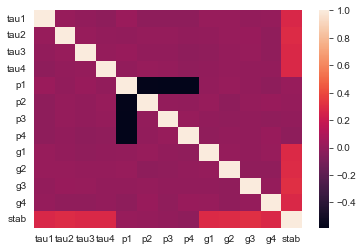

In [43]:
# 查看各列相关性,p1 = abs(p2 + p3 + p4),p1和p2、p3和p4为负相关
corr = data.corr()
corr.head()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.show()

In [44]:
# 获取data的列名['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab', 'stabf']
name_list = data.columns.values.tolist()
print(name_list)

['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab', 'stabf']


In [45]:
# 获取预测属性
X = data.drop(['p1','stab','stabf'],axis=1)
print(X.head().T)

             0         1         2         3         4
tau1  2.959060  9.304097  8.971707  0.716415  3.134112
tau2  3.079885  4.902524  8.848428  7.669600  7.608772
tau3  8.381025  3.047541  3.046479  4.486641  4.943759
tau4  9.780754  1.369357  1.214518  2.340563  9.857573
p2   -0.782604 -1.940058 -1.207456 -1.027473 -1.125531
p3   -1.257395 -1.872742 -1.277210 -1.938944 -1.845975
p4   -1.723086 -1.255012 -0.920492 -0.997374 -0.554305
g1    0.650456  0.413441  0.163041  0.446209  0.797110
g2    0.859578  0.862414  0.766689  0.976744  0.455450
g3    0.887445  0.562139  0.839444  0.929381  0.656947
g4    0.958034  0.781760  0.109853  0.362718  0.820923


In [46]:
# 类别标签
y = data['stabf']
print(y)

0       unstable
1         stable
2       unstable
3       unstable
4       unstable
          ...   
9995    unstable
9996      stable
9997      stable
9998    unstable
9999    unstable
Name: stabf, Length: 10000, dtype: object


In [47]:
# 将标签字符转换成数字
# 获取一个LabelEncoder
enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)

In [48]:
# 划分训练集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [49]:
# 配置参数
param = {'n_estimators':list((50,100,300)),'max_depth':list((3,5,7,9)),'criterion':['gini','entropy']}
# 随机森林模型
forest = RandomForestClassifier(param)
# 用GridSearchCV进行调参
gsearsh = GridSearchCV(estimator=forest,param_grid=param,n_jobs=-1).fit(X_train, y_train)

In [50]:
# 最优的参数,类型为字典dict
best_param = gsearsh.best_params_
print(best_param)

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}


In [51]:
# 使用经过网格搜索得到的最优参数,n_jobs=-1表示用上所有的处理器
rfc = RandomForestClassifier(n_estimators = best_param["n_estimators"],
                            criterion=best_param["criterion"], oob_score=True,n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, oob_score=True)

In [52]:
# 对y_test进行预测
y_pred = rfc.predict(X_test)
# predict_proba返回的是对于预测为0/1的概率
y_proba = rfc.predict_proba(X_test)
# 正例的概率
y_scores = y_proba[:,1]

In [53]:
# 输出混淆矩阵,混淆矩阵格式如下:
# [TN FP]
# [FN TP]
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix is \n",cm)
# confusion_matrix(混淆矩阵), display_labels(标签名称列表)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])

Confusion matrix is 
 [[ 791  140]
 [  71 1498]]


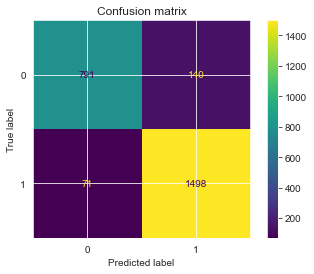

In [54]:
# 绘制混淆矩阵
disp.plot()
plt.title("Confusion matrix")
plt.show()

In [55]:
# 准确率accuracy=(TP+TN)/(TP+FP+TN+FN)
print("Accuracy of Label is ",accuracy_score(y_test,y_pred))

Accuracy of Label is  0.9156


In [56]:
# 精确度 P = TP / (TP + FP)
print("Precision of Label is ",precision_score(y_test,y_pred))

Precision of Label is  0.9145299145299145


In [57]:
# 召回率R = TP / (TP + FN)
print("Recall of Label is",recall_score(y_test,y_pred))

Recall of Label is 0.9547482472912683


In [58]:
# F1度量 F1 = (2 x P x R) / (P + R)
print("F1 of Label is",f1_score(y_test,y_pred))

F1 of Label is 0.934206423448706


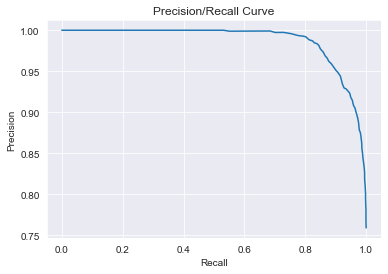

In [59]:
# 绘制P-R曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.figure("P-R Curve")
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall,precision)
plt.show()

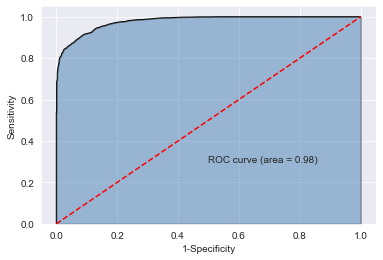

In [60]:
# 绘制ROC曲线
from sklearn import metrics
# 计算不同阈值下，fpr和tpr的组合值，其中fpr表示1-Specificity，tpr表示Sensitivity
fpr,tpr,threshold = metrics.roc_curve(y_test, y_scores)

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()